In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/"
%cd candlestick_patterns/

In [ ]:
pip install --upgrade mplfinance

**Plotting Candlesticks**

Saving each two day candlestick pattern into a folder

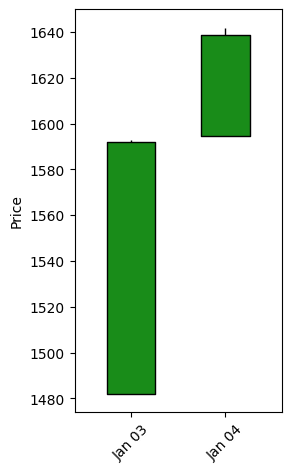

In [3]:
import pandas as pd
import os
import mplfinance as mpf
df = pd.read_csv("NIFTY 50.csv",index_col="Date")
df.index = pd.to_datetime(df.index,dayfirst=True)
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='candle')
#path=os.path.join(os.getcwd(),'double')
#os.chdir(path)
#for i in range (5353):
#    mpf.plot(df[i:i+2],**kwargs,style=s,scale_width_adjustment=dict(candle=0.8),figratio=(8,16),savefig=dict(fname='daily'+str(df.index[i])[:10],dpi=100,pad_inches=0.25))
#    print(i)

mpf.plot(df[0:2],**kwargs,style=s,scale_width_adjustment=dict(candle=0.8),figratio=(8,16)) 

**Loading and Resizing Data**

Resizing data into a (224,244,3)

In [6]:
import os
zip_path = '/content/gdrive/My Drive/candlestick_patterns/double.zip'
!cp "{zip_path}" .
!unzip -q double.zip
#!rm double.zip

cp: '/content/gdrive/My Drive/candlestick_patterns/patterns.zip' and './patterns.zip' are the same file


In [4]:
import cv2
import numpy as np
import pandas as pd
import mplfinance as mpf
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten,Dropout,InputLayer
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split

In [5]:
def get_data(data_dir=os.getcwd()):
    data = [] 
    i=0
    path = os.path.join(data_dir, "double")
    for img in os.listdir(path):
      try:
          img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
          resized_arr = cv2.resize(img_arr, (64, 64)) # Reshaping images to preferred size
          data.append(resized_arr)
          print(i)
          i=i+1
      except Exception as e:
          print(e)


    return np.array(data)

In [ ]:
data=get_data()

(-0.5, 63.5, 63.5, -0.5)

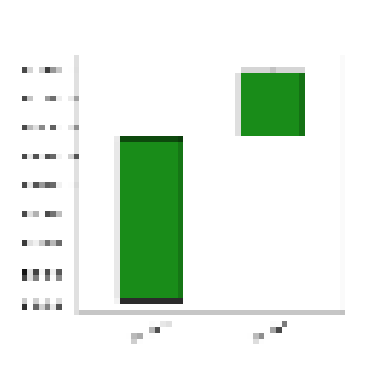

In [7]:
plt.imshow(data[0])
plt.axis('off')

**Bullish/Bearish Engulfing**

---



**Determing Target Label**

Bullish Engulfing - 1

Bearish Engulfing - 2

None - 0

In [ ]:
Y=[]
for i in range(5352):
  if ( (df.iloc[i].Close<df.iloc[i].Open) & (df.iloc[i+1].Close>df.iloc[i+1].Open) & (df.iloc[i].Open<df.iloc[i+1].Close) & (df.iloc[i].Close>df.iloc[i+1].Open) ):
      #df.iloc[i]['engulfing']=1
      print("1")
      Y.append(1)
  elif ( (df.iloc[i].Close>df.iloc[i].Open) & (df.iloc[i+1].Close<df.iloc[i+1].Open) & (df.iloc[i].Open>df.iloc[i+1].Close) & (df.iloc[i].Close<df.iloc[i+1].Open) ):
    #df['engulfing']=2
    Y.append(2)
    print("2")
  else:
    #df['engulfing']=0
    Y.append(0)
    print("0")

Y=pd.DataFrame(Y)
Y.to_csv("Y_engulfing.csv")

**Loading Target Label**

In [8]:
y=pd.read_csv('/content/gdrive/My Drive/candlestick_patterns/Y_engulfing.csv')
print(y.iloc[:,1].value_counts())
y  = to_categorical(y.iloc[:,1])
y.shape

0    4924
2     275
1     153
Name: 0, dtype: int64


(5352, 3)

**Initializing the CNN Model**

In [9]:
def split(X,y):
  X=X/255.0
  X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  X_train,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
  return X_train,y_train,X_val,y_val,X_test,y_test

In [10]:
def model_engulfing():

  model = Sequential()
  model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform' ,activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  #model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform' ,activation='relu', input_shape=(64,64,3)))
  #model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(1024,kernel_initializer='normal',activation="relu"))
  #model.add(Dropout(0.4))
  #model.add(Dense(256,kernel_initializer='normal',activation="relu"))
  model.add(Dense(3, activation="softmax"))

  model.summary()

  return model

In [45]:
X_train,y_train,X_val,y_val,X_test,y_test = split(data,y)

**Model Training**

In [49]:
from tensorflow.keras.optimizers import SGD
model=model_engulfing()
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train, batch_size=128, epochs=5,validation_data=(X_val,y_val))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 30752)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              31491072  
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 3075      
Total params: 31,495,043
Trainable params: 31,495,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


26/26 [==============================] - 2s 51ms/step - loss: 13.7050 - accuracy: 0.8903 - val_loss: 12.2144 - val_accuracy: 0.9244
Epoch 2/5
26/26 [==============================] - 1s 43ms/step - loss: 4.5150 - accuracy: 0.9249 - val_loss: 0.7480 - val_accuracy: 0.9244
Epoch 3/5
26/26 [==============================] - 1s 43ms/step - loss: 0.4641 - accuracy: 0.9112 - val_loss: 0.2876 - val_accuracy: 0.9057
Epoch 4/5
26/26 [==============================] - 1s 42ms/step - loss: 0.2122 - accuracy: 0.9187 - val_loss: 0.1946 - val_accuracy: 0.9262
Epoch 5/5
26/26 [==============================] - 1s 42ms/step - loss: 0.1610 - accuracy: 0.9321 - val_loss: 0.1490 - val_accuracy: 0.9253


**Plotting Results**

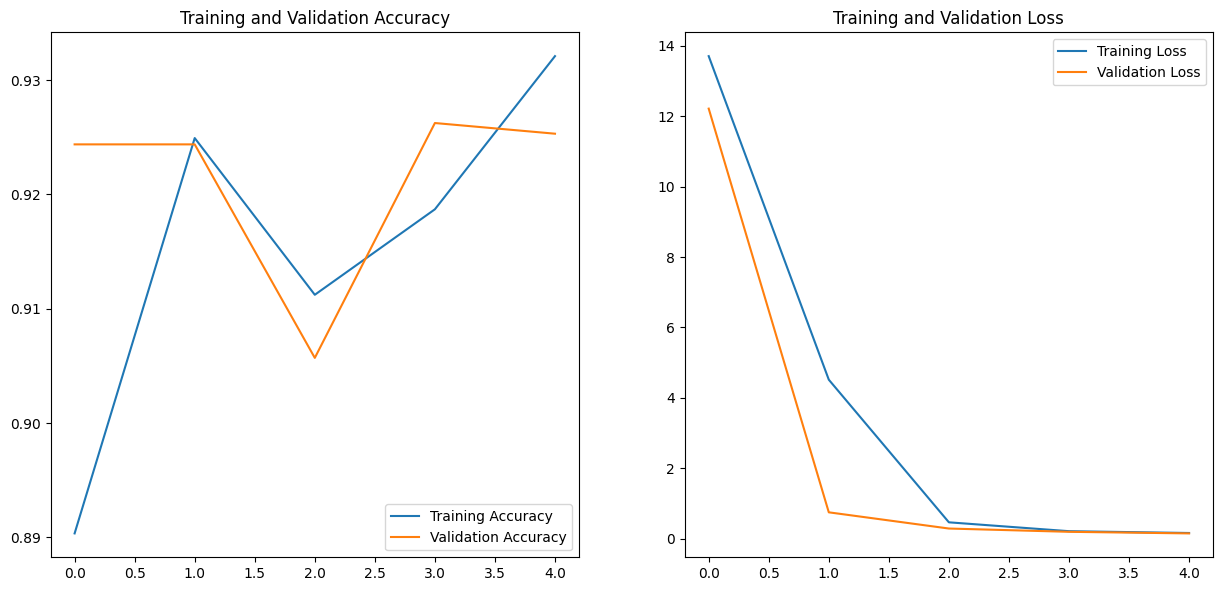

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
_, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))

from sklearn.metrics import classification_report
#x_test,y_true = test_iterator.next()
pred = model.predict(X_test)

#predictions = predictions.reshape(1,-1)[0]
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

Test Accuracy: 91.877
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       974
           1       0.54      0.76      0.63        66
           2       0.59      0.32      0.42        31

    accuracy                           0.92      1071
   macro avg       0.70      0.68      0.67      1071
weighted avg       0.92      0.92      0.92      1071



**Bullish/Bearish Harami**

---




**Determing Target Label**

Bullish Harami - 1

Bearish Harami - 2

None - 0

In [ ]:
Y=[]
for i in range(5352):
  if ( (df.iloc[i].Close<df.iloc[i].Open) & (df.iloc[i+1].Close>df.iloc[i+1].Open) & (df.iloc[i].Open>df.iloc[i+1].Close) & (df.iloc[i].Close<df.iloc[i+1].Open) ):
    Y.append(1)
  elif ( (df.iloc[i].Close>df.iloc[i].Open) & (df.iloc[i+1].Close<df.iloc[i+1].Open) & (df.iloc[i].Open<df.iloc[i+1].Close) & (df.iloc[i].Close>df.iloc[i+1].Open) ):
    Y.append(2)
  else:
    Y.append(0)

Y=pd.DataFrame(Y)
Y.to_csv("Y_harami.csv")  

**Loading Target Label**

In [15]:
y=pd.read_csv('/content/gdrive/My Drive/candlestick_patterns/Y_harami.csv')
print(y.iloc[:,1].value_counts())
y  = to_categorical(y.iloc[:,1])
y.shape

0    4935
1     275
2     142
Name: 0, dtype: int64


(5352, 3)

**Model Initializing**

In [16]:
def model_harami():

  model = Sequential()
  model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform' ,activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform' ,activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(1024,kernel_initializer='normal',activation="relu"))
  #model.add(Dropout(0.4))
  #model.add(Dense(256,kernel_initializer='normal',activation="relu"))
  model.add(Dense(3, activation="softmax"))

  model.summary()

  return model

In [52]:
X_train,y_train,X_val,y_val,X_test,y_test = split(data,y)

**Model Training**

In [53]:
from tensorflow.keras.optimizers import SGD
model=model_harami()
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train, batch_size=128, epochs=5,validation_data=(X_val,y_val))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              12846080  
_________________________________________________________________
dense_23 (Dense)             (None, 3)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


26/26 [==============================] - 2s 47ms/step - loss: 2.1865 - accuracy: 0.8888 - val_loss: 0.2321 - val_accuracy: 0.9281
Epoch 2/5
26/26 [==============================] - 1s 38ms/step - loss: 0.1598 - accuracy: 0.9277 - val_loss: 0.1248 - val_accuracy: 0.9300
Epoch 3/5
26/26 [==============================] - 1s 37ms/step - loss: 0.1085 - accuracy: 0.9340 - val_loss: 0.1027 - val_accuracy: 0.9458
Epoch 4/5
26/26 [==============================] - 1s 38ms/step - loss: 0.0886 - accuracy: 0.9417 - val_loss: 0.0995 - val_accuracy: 0.9412
Epoch 5/5
26/26 [==============================] - 1s 37ms/step - loss: 0.0833 - accuracy: 0.9452 - val_loss: 0.0943 - val_accuracy: 0.9421


**Plotting Results**

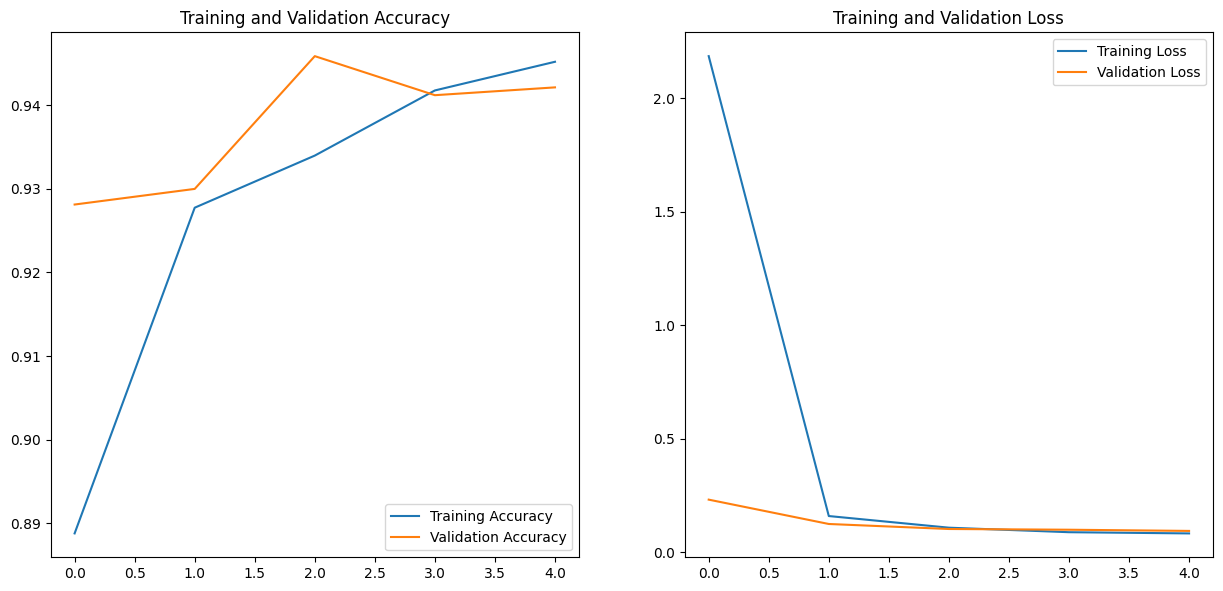

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
_, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))

from sklearn.metrics import classification_report

pred = model.predict(X_test)

y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

Test Accuracy: 93.744
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       974
           1       0.69      0.68      0.69        66
           2       0.73      0.26      0.38        31

    accuracy                           0.94      1071
   macro avg       0.79      0.64      0.68      1071
weighted avg       0.93      0.94      0.93      1071

